# Feature: attenuation correction (`removeRange`)

This notebook covers the development of a method to determine (and correct for) an attenuation/absorption in DIDSON data.

In [2]:
import sys 
import os
sys.path.append(os.path.abspath("..")) 

#
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# to get at test data
from glob import glob 
from skimage.io import imread 

import sonar

In [3]:
from sonar import Sonar
from didson import Didson

didson = Didson();
didson.loadConfig('../data/DIDSON/didson.json')

Resolution
Desired: 0.02 , x: 0.0199847165996 , y: 0.0200030206842
Resolution
Desired: 0.02 , x: 0.0199794887389 , y: 0.01998400879


In [20]:
didson.noise=0.05

In [13]:
didson.taper

array([ 0.26174413,  0.25577315,  0.26399879,  0.28787933,  0.29545828,
        0.29054691,  0.31506358,  0.31670595,  0.27838829,  0.27740946,
        0.31381202,  0.34471729,  0.29504131,  0.30120893,  0.35612588,
        0.39107684,  0.47706575,  0.50165683,  0.64432888,  0.70103061,
        0.52937032,  0.55136364,  0.69209224,  0.77736692,  0.57242255,
        0.57178564,  0.56410725,  0.60761842,  0.61531377,  0.63170835,
        0.6202898 ,  0.65340297,  0.81404225,  0.80500209,  0.75957603,
        0.7744332 ,  0.79802742,  0.82697358,  0.81318299,  0.81549321,
        0.98650338,  0.98515214,  1.        ,  0.92161883,  0.95219957,
        0.9486457 ,  0.92306306,  0.92623384,  0.74438512,  0.6791569 ,
        0.71338905,  0.70997648,  0.67387443,  0.64784864,  0.70079313,
        0.67144433,  0.69643358,  0.64901154,  0.66355446,  0.65517472,
        0.60723509,  0.57099174,  0.58697568,  0.57716755,  0.62179199,
        0.6931046 ,  0.59655172,  0.55023343,  0.55222214,  0.64

In [15]:
didson.psf

array([[ 0.06185567,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.06185567,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.06185567,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.06958763,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.08247423,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.10309278,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.18041237,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.10309278,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.08247423,
         0.        ,  0.        ,  0.        ,  0. 

In [5]:
# test_image_list = glob('/home/pvt/Workspace/Data/HAUV/DIDSON/synth/dataset-1/*raw.png') 
test_image_list = glob('/home/pvt/Workspace/Data/HAUV/DIDSON/2016-07-19.11/0182/*raw.png') 
print len(test_image_list)

# two sets of images observing open water (no objects) with window range from 2.25 to 11.25m (9m window)
bg_image_list_1 = glob('/home/pvt/Workspace/Data/HAUV/DIDSON/synth/dataset-2/*raw.png') # window set to 2.25m to 11.25m
print len(bg_image_list_1)
bg_image_list_2 = glob('/home/pvt/Workspace/Data/HAUV/DIDSON/synth/dataset-3/*raw.png') # 
print len(bg_image_list_2)

98
116
270


In [6]:
def computeAttenuation(image_list, sonar):
    
    N = len(image_list)
    attenuation = np.zeros(sonar.num_bins, dtype = np.float64)
    for i in range(0,N):
        ping = imread(image_list[i],as_grey=True)
        ping = ping.astype(np.float64)
        ping = sonar.deconvolve(ping)
        ping = sonar.removeTaper(ping)
        att = np.sum(ping, axis = 1)
        att/=(att.max()+0.0)
        attenuation += att
    attenuation/=(N+0.0)
    attenuation/=np.amax(attenuation)
    
    return attenuation

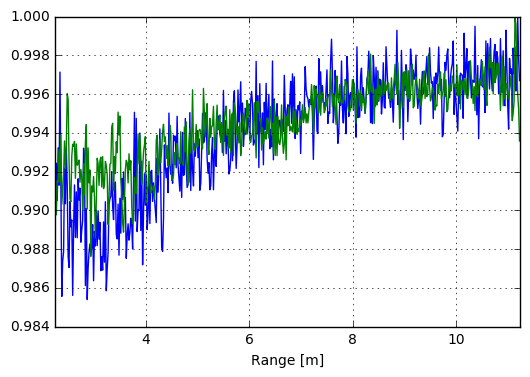

In [7]:
at1 = computeAttenuation(bg_image_list_1, didson)
at2 = computeAttenuation(bg_image_list_2, didson)

bin_length = (didson.max_range-didson.min_range)/didson.num_bins
r = didson.min_range + bin_length*np.arange(0, didson.num_bins)

plt.figure()
plt.plot(r,at1)
plt.plot(r,at2)
# plt.xscale('log')
# plt.yscale('log')

plt.grid(b=True, which='both')
# plt.grid(b=True, which='major',linestyle='-')
# plt.grid(b=True, which='minor',linestyle='--')
plt.xlim([didson.min_range, didson.max_range])
plt.xlabel('Range [m]')


In [8]:
from scipy.optimize import curve_fit

(512,)
(512,)
Test set 1 - model parameters: 0.982784409481 0.000135401526875 -0.00678615529325
Test set 2 - model parameters: 0.98897427557 -0.000336450722219 -0.00183934656482


/home/pvt/miniconda2/envs/multibeam/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp
/home/pvt/miniconda2/envs/multibeam/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in multiply
/home/pvt/miniconda2/envs/multibeam/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in divide


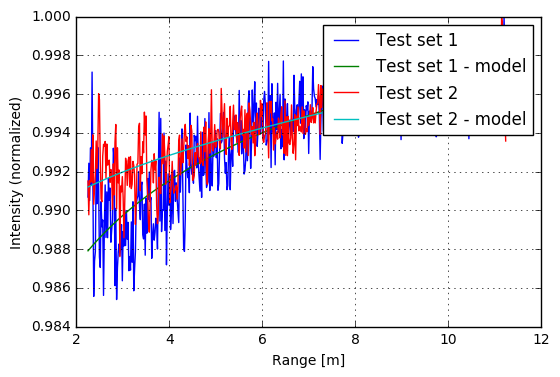

In [9]:
def attenuation(r, a, b, c):
#     return a*np.log10(r) + b # spreading model (need to add absorption losses)
#     return a*np.exp(-r) + b # negative exponential
#     return a/(r**b) + c # 
    return a*np.exp(-b*r)/(r**c)
#     return a/(r-b)**c

xdata = 2.25 + (9.0/512)*np.arange(0,512)
print xdata.shape
ydata = np.squeeze(at1)
print ydata.shape

p, v = curve_fit(attenuation, xdata, np.squeeze(at1), p0=[1,1,1])
print 'Test set 1 - model parameters:',p[0], p[1], p[2]

at_est = attenuation(xdata, p[0], p[1], p[2])

plt.plot(xdata, np.squeeze(at1))
plt.plot(xdata, at_est)

p, v = curve_fit(attenuation, xdata, np.squeeze(at2), p0=[1,1,1])
print 'Test set 2 - model parameters:', p[0], p[1], p[2]

at_est = attenuation(xdata, p[0], p[1], p[2])

plt.plot(xdata, np.squeeze(at2))
plt.plot(xdata, at_est)
plt.grid(b=True, which='both')
plt.xlabel('Range [m]')
plt.ylabel('Intensity (normalized)')
plt.legend(['Test set 1','Test set 1 - model','Test set 2', 'Test set 2 - model'])
plt.savefig("range.png",transparent=True,pad_inches=0.0)

In [20]:
def removeAttenuation(ping, attenuation):
    attenuation.shape = (len(attenuation),1)
    att = np.tile(attenuation, (1,ping.shape[1]))
    ping2 = ping.astype(np.float64)
    ping2/=att
    ping2*=((ping.max()+0.0)/ping2.max())
    return ping2

In [22]:
def computeHist(ping):
    bins = np.arange(0,256)
    
    h = np.histogram(ping, bins)
       
    return (bins, (h[0]+0.0)/np.sum(h[0])) 

58
0 255
0.0 255.0
0.0 255.0
0.0 255.0
Resolution
Desired: 0.01 , x: 0.0100007584206 , y: 0.00999200439502
(512, 96)


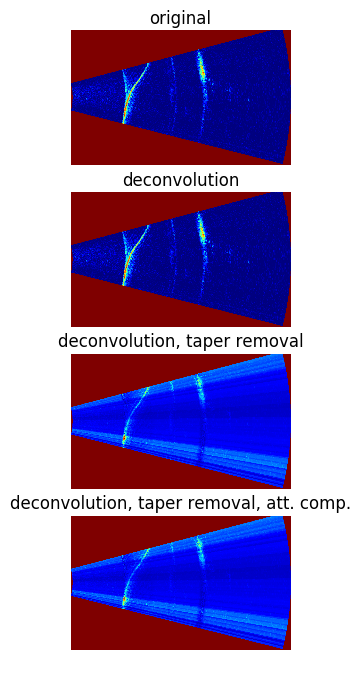

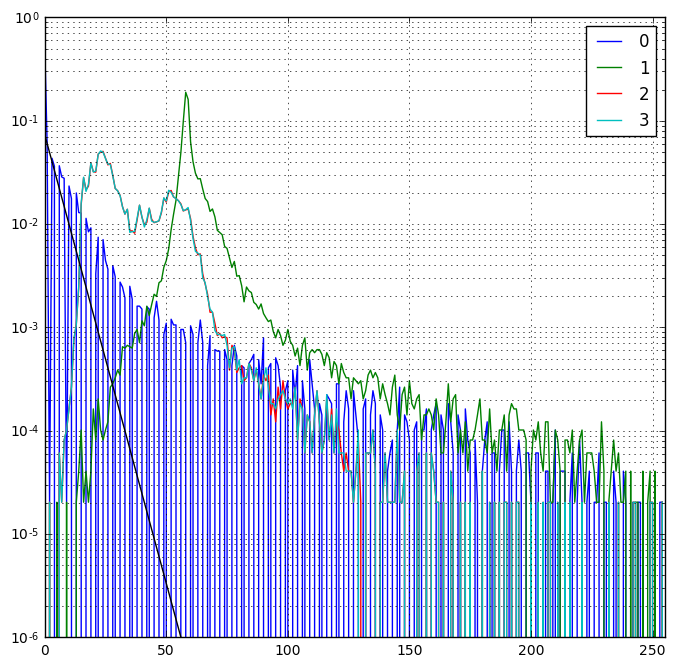

In [22]:
# image_list = bg_image_list_1
image_list = test_image_list

idx = np.random.randint(0,len(image_list))
# idx = 8
print idx

ping0 = imread(image_list[idx],as_grey=True)
print ping0.min(), ping0.max()
(b, h0) = computeHist(ping0)

ping1 = didson.deconvolve(ping0)
print ping1.min(), ping1.max()
(b, h1) = computeHist(ping1)

ping2 = didson.removeTaper(ping1)
print ping2.min(), ping2.max()
(b, h2) = computeHist(ping2)

ping3 = removeAttenuation(ping2, at_est)
print ping3.min(), ping3.max()
(b, h3) = computeHist(ping3)

didson.resetWindow(2.25,11.25,0.01)

colormap = 'gray'
colormap = 'jet'

plt.figure(figsize=(20,8))
plt.subplot(4,1,1)
ping0c=didson.toCart(ping0,width=320,bg=255.0)
plt.imshow(ping0c.transpose(),vmin=0,vmax=255,cmap=colormap)
plt.title('original')
plt.axis('off')
plt.subplot(4,1,2)

plt.imshow(ping0c.transpose(),vmin=0,vmax=255,cmap=colormap)
plt.title('deconvolution')
plt.axis('off')
plt.subplot(4,1,3)
ping2c = didson.toCart(ping2,width=320,bg=255.0)
plt.imshow(ping2c.transpose(),vmin=0,vmax=255,cmap=colormap)
plt.title('deconvolution, taper removal')
plt.axis('off')
plt.subplot(4,1,4)
ping3c = didson.toCart(ping3,width=320,bg=255.0)
plt.imshow(ping3c.transpose(),vmin=0,vmax=255,cmap=colormap)
plt.title('deconvolution, taper removal, att. comp.')
plt.axis('off')


plt.figure(figsize=(8,8))
plt.plot(b[:-1],h0)

plt.plot(b[:-1],h1)
plt.plot(b[:-1],h2)
plt.plot(b[:-1],h3)
plt.yscale('log')
plt.grid(b=True, which='both')
plt.xlim([0,255])
plt.ylim([1e-6,1e0])
plt.legend(('0','1','2','3'))

from scipy import stats
plt.plot(b[:-1], stats.expon.pdf(b[:-1], loc=-5,scale=5),color='k' )

print ping1.shape